---

# Assignment 10: CNN part 2 (deadline: 20 Jan, 23:59)

## 1. Implementing CNN (10 points)

Here you will implement a simple, but efficient Convolutional Neural Network (CNN) in TensorFlow for image classification task on CIFAR-10 dataset ([link and description](https://www.cs.toronto.edu/~kriz/cifar.html), but please note that the section "Baseline results" is completely outdated). 

We strongly recommend you first to go through a very good [tutorial from TensorFlow](https://www.tensorflow.org/get_started/mnist/pros). You can borrow implementation details from them, especially for convolutions and pooling layers, but make sure to implement our architecture! If you just apply the architecture from that tutorial to CIFAR-10 dataset, you will not receive many points. And please note, that this tutorial considers MNIST dataset, which has grayscale digits. However, CIFAR-10 has images in RGB. There is also another [tutorial by TensorFlow](https://www.tensorflow.org/tutorials/deep_cnn), which shows AlexNet architecture (now outdated!) applied to CIFAR-10. But it is much more advanced than the first one.

Also you may find useful to check these excellent materials http://cs231n.github.io/convolutional-networks/ and http://cs231n.github.io/understanding-cnn/ from Stanford University for general explanations about CNNs.


Specifically for this exercise we decided to invent a slightly new CNN architecture, which combines some ideas from recent research papers. Here it is:

| Layer | Number of units |
|-------| ---|
| input layer   | 32x32x3 units |
| 5x5 conv+ReLU, stride 1, 10 filters| 32x32x10 units |
| 3x3 max pool, stride 2 | 16x16x10 units |
| 4x4 conv+ReLU, stride 1, 20 filters | 16x16x20 units | 
| 3x3 max pool, stride 2 | 8x8x20 units |
| 3x3 conv+ReLU, stride 1, 30 filters | 8x8x30 units | 
| global average pooling | 30 units |
| fully-connected | 10 units (classes) | 
| softmax | 10 units (classes) |
| cross-entropy loss with L2 regularization | 1 unit (objective) |

**Our main expectation for this task is "good" test error (around 35-40% after 10 epochs) and correct implementation of the given architecture.** Of course, it is very far away from the state-of-the-art for this dataset, which is around 3%. But unfortunately, really deep CNNs cannot be trained on ordinary laptops.


Implementation details:
- Initialize your weights with He initialization (for your interest, [original paper](https://arxiv.org/pdf/1502.01852.pdf)), which is simply a normal distribution with mean=0 and std=sqrt(2/n), where n is the number of units on the next layer (note that for convolutional layer with 5x5 convolutions and 10 convolutional filters, we have $n=5 \cdot 5 \cdot 10$).
- Convolution should preserve dimensions (use 'SAME'). 
- Global average pooling means that we simply average all our values inside each feature map. So on the 3-rd convolutional layer we have 30 feature maps of size 8x8. After global average pooling we get only 30 values of averaged 8x8 feature maps.
- Use ReLU as activaton function
- We use softmax + cross-entropy loss, and no elementwise sigmoids. Make sure that you use average cross-entropy per batch in order to make an update! Otherwise recommended lambda and learning rate will not be a good choice.
- For optimization you can use Adam with the learning rate given above (0.005), and all other parameters set by default. 
- Please train the model for 10 epochs with batch size = 100. Please note, that 10 epochs is not actually a lot, and we can get substantial improvement if we go beyond 10 epochs. We just want to be sure that 10 epochs can be done in a reasonable amount of time on any kind of laptop that you may have.
- Use TensorBoard to **display the computation graph** defined by your model. Additonally, use TensorBoard to **log the test error, training error and training loss function** of your network for each epoch (again, you can use [here](https://www.tensorflow.org/get_started/summaries_and_tensorboard) for reference). To speed up the training process, it's not necessary to report training accuracy on all 50000 examples, you can just take first 1000 examples.
- Don't forget about L2 regularization of all weights (both convolutional and fully connected). Recommended $\lambda$ is 0.0001.
- Of course, feel free to use different hyperparameters if you find better ones.

Here is the code to load and standardize features of CIFAR-10 dataset. So the simplest version is to load CIFAR-10 using [Tensorpack](https://github.com/ppwwyyxx/tensorpack), which you have to install first. 

In [ ]:
import tensorpack.dataflow.dataset as dataset
import numpy as np
train, test = dataset.Cifar10('train'), dataset.Cifar10('test')

# useful to reduce this number to 1000 for debugging purposes
n = 50000
x_train = np.array([train.data[i][0] for i in range(n)], dtype=np.float32)
y_train = np.array([train.data[i][1] for i in range(n)], dtype=np.int32)
x_test = np.array([ex[0] for ex in test.data], dtype=np.float32)
y_test = np.array([ex[1] for ex in test.data], dtype=np.int32)

del(train, test)  # frees approximately 180 MB

# standardization
x_train_pixel_mean = x_train.mean(axis=0)  # per-pixel mean
x_train_pixel_std = x_train.std(axis=0)   # per-pixel std
x_train -= x_train_pixel_mean
x_train /= x_train_pixel_std
x_test -= x_train_pixel_mean
x_test /= x_train_pixel_std

Note, that you do not have a validation set here, only training and test sets. Of course, a more principled way is to select your hyperparameters based on the validation set and then retrain the model on training and validation sets combined and then report the final performance on the test set. But it would be too complicated for this assignment.

*Hint1: it should be possible to train this CNN on an average laptop (for reference, let's take the processor Intel® Core™ i5-3210M CPU @ 2.50GHz × 4) in 12 minutes and using up to 1 GB RAM (only the dataset needs 60000 images * 32 pixels * 32 pixels * 3 colors * 4 bytes $\approx$ 737 MB after standardization which necessarily converts uint8 to float32). The final test error after 10 epochs should be around 35-40%. For the reference, you can see the optimization log of the correct solution (but of course, you will have random initialization and random shuffling of batches, which makes exactly these numbers not reproducible):*

| Epoch | Test error | Train error |
| --- | -- |
| 1  | 49.300%  | 50.200% |
| 2  | 44.310%  | 45.000% |
| 3  | 43.110%  | 40.700% |
| 4  | 39.550%  | 38.700% |
| 5  | 39.820%  | 39.900% |
| 6  | 38.480%  | 37.000% |
| 7  | 36.180%  | 35.100% |
| 8  | 36.810%  | 37.600% |
| 9  | 35.340%  | 34.800% |
| 10 | 35.210%  | 34.900% |

*Hint2: you may find `tf.nn.sparse_softmax_cross_entropy_with_logits` useful if you don't want to convert the labels into 1-hot encoding.*

*Hint3: you should shuffle batches on each iteration, so you can make use of this function:*
```
def get_next_batch(X, Y, batch_size):
    n_batches = len(X) // batch_size
    rand_idx = np.random.permutation(len(X))[:n_batches * batch_size]
    for batch_idx in rand_idx.reshape([n_batches, batch_size]):
        batch_x, batch_y = X[batch_idx], Y[batch_idx]
        yield batch_x, batch_y
```
        
*Hint4: if you have limited amount of RAM on your laptop (if you don't have any problems with memory, then it's not necessary), you can evaluate test and training errors also by batches and then combine them into the final test/train error. For example like this:*
```
def eval_error(X_np, Y_np, sess, batch_size):
    """Get all predictions for a dataset by running it in small batches."""
    n_batches = len(X_np) // batch_size
    err = 0.0
    for batch_x, batch_y in get_next_batch(X_np, Y_np, batch_size):
        err += sess.run(error_rate, feed_dict={x: batch_x, y: batch_y})
    return err / n_batches
```

*Hint5: you can implement the weight decay in the following way (if you named all your weights variable with the name that contains some `var_pattern`):*
```
def weight_decay(var_pattern):
    """
    L2 weight decay loss, based on all weights that have var_pattern in their name

    var_pattern - a substring of a name of weights variables that we want to use in Weight Decay.
    """
    costs = []
    for var in tf.trainable_variables():
        if var.op.name.find(var_pattern) != -1:
            costs.append(tf.nn.l2_loss(var))
    return tf.add_n(costs)
```

*Hint6: it is a very good idea to debug your code only on a subset of CIFAR-10 (let's say, 1000 examples), so you can quickly see if things go wrong.*


In [ ]:
import sys
import os
import numpy as np
import tensorflow as tf


# Hyperparams
batch_size = 100
num_epochs = 10
learning_rate = 0.005
reg_lambda = 0.0001
init_mean = 0.0
random_seed = 2
num_classes = 10


def weight_decay(var_pattern):
    """
    L2 weight decay loss, based on all weights that have var_pattern in their name
    :param var_pattern: a substring of a name of weights variables that we want to use in Weight Decay.
    :return: sum over decayed weights
    """
    costs = []
    for var in tf.trainable_variables():
        if var.op.name.find(var_pattern) != -1:
            costs.append(tf.nn.l2_loss(var))
    return tf.add_n(costs)


def weight_list(var_pattern):
    """
    Returns a list of variables matching var_pattern
    """
    vars = []
    for var in tf.trainable_variables():
        if var.op.name.find(var_pattern) != -1:
            vars.append(var)
    return vars


def get_next_batch(X, Y, bsize):
    """
    
    :param X:
    :param Y:
    :param bsize:
    :return:
    """
    n_batches = len(X) // bsize
    rand_idx = np.random.permutation(len(X))[:n_batches * bsize]
    for batch_idx in rand_idx.reshape([n_batches, bsize]):
        batch_x, batch_y = X[batch_idx], Y[batch_idx]
        yield batch_x, batch_y
        


def init_std_dev(num_units):
    """
    Standard deviation
    :param num_units: number of units in the next layer
    :return: std dev
    """
    return np.sqrt(2.0/num_units)


def init_bias(shape):
    """
    Initializes bias tensor for the provided shape
    :param shape: shape array
    :return: bias tensor
    """
    return tf.zeros(shape)
    

def get_filter(shape, name):
    """
    Creates a new filter variable.
    :param shape: shape of the filter tensor
    :param name: name of the filter tensor
    :return: tf.Variable
    """
    return tf.get_variable(dtype=tf.float32,
                           initializer=tf.random_normal(shape=shape,
                                                        mean=init_mean,
                                                        stddev=init_std_dev(shape[0] * shape[1] * shape[3]),
                                                        seed=random_seed),
                           name=name)


def conv_layer(x, stride, filter_dims, num_filters, layer_index):
    """
    Creates a convolution layer.
    :param x: input tensor of shape []
    :param stride: int stride
    :param filter_dims: (width, height) tuple indicating filter dimensions
    :param num_filters: number of filters
    :param layer_index: index used to name the layer variable
    :return: the convolution layer
    """
    w, h = filter_dims  # dimensions of filter kernel
    in_units = x.get_shape().as_list()[3]  # number of output channels from previous layer (used as input here)
    fshape = [w, h, in_units, num_filters]
    filt = get_filter(fshape, 'filter{}_W'.format(layer_index))

    conv = tf.nn.conv2d(x,
                        filter=filt,
                        strides=[1, stride, stride, 1],
                        padding='SAME')
    with tf.name_scope('bias'):
        bias = tf.get_variable(initializer=init_bias(num_filters),
                               dtype=tf.float32, name='bias_{}'.format(layer_index))
    tf.nn.bias_add(conv, bias)
    
    return conv, filt


def global_average_pooling(x):
    """
    Global average pooling layer.
    :param x: input tensor of shape [xdim, ydim, nchannels]
    :return: shape [nchannels] tensor containing average over [xdim, y dim] for each channel
    """
    return tf.reduce_mean(x, axis=[1, 2], name='global_average_pool')


def fully_connected_layer(x, out_units):
    """
    Creates a fully connected layer Wx + b
    :param x: input tensor of shape
    :param out_units: number of output units
    :return: the fully connected layer
    """
    shape = tf.cast(x.shape[1], tf.int32), out_units
    W = tf.get_variable(initializer=tf.random_normal(mean=init_mean,
                                                     stddev=init_std_dev(out_units),
                                                     shape=shape,
                                                     seed=random_seed),
                        dtype=tf.float32,
                        name='fc_W')
    bias = tf.get_variable(initializer=init_bias(out_units),
                           dtype=tf.float32,
                           name='fc_b')
    lin_comb = tf.matmul(x, W)
    return tf.nn.bias_add(lin_comb, bias)


# cross-entropy loss with L2 reg   1 unit (objective)
def ce_loss_with_l2(logits, y, lamb):
    """
    Computes cross-entropy loss with L2 regularization, also applies softmax to the inputs.
    :param logits: prediction tensor
    :param y: labels
    :param lamb: regularization parameter
    :return: loss value
    """
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name='cross_entropy')
    cmean = tf.reduce_mean(ce)
    reg_term = tf.multiply(lamb, weight_decay('_W'))
    return tf.add(cmean, reg_term)


def error_rate(pred, truth):
    """
    Computes the error rate for predictions.
    :param pred: prediction tensor
    :param truth: labels tensor
    :return: error rate (scalar)
    """
    with tf.name_scope('error_rate'):
        acc = tf.nn.in_top_k(pred, truth, 1)
    return 1.0 - tf.reduce_mean(tf.cast(acc, tf.float32))


def eval_error(X_np, Y_np, session, bsize, err_op):
    """
    Computes error for all predictions in the dataset by running it in small batches.
    :param X_np: images
    :param Y_np: labels
    :param session: tensorflow session instance
    :param bsize: batch size
    :param err_op: the error computation
    :return: error rate for the entire dataset
    """
    n_batches = len(X_np) // bsize
    err = 0.0
    for batch_x, batch_y in get_next_batch(X_np, Y_np, bsize):
        err += session.run(err_op, feed_dict={images: batch_x, labels: batch_y})
    error = err / n_batches
    return error


def log_filter(filt):
    # log filter in tensorboard
    w, h, in_units, num_filters = filt.shape.as_list()
    if in_units == 3:
        # color image
        tf.summary.image('filter', tf.transpose(filt, perm=[3, 0, 1, 2]), max_outputs=num_filters,
                         collections=['per_epoch'])
    else:
        filt_reduced = tf.reshape(tf.unstack(filt, axis=2)[0], [w, h, 1, num_filters])  # only show channel #0
        tf.summary.image('filter', tf.transpose(filt_reduced, perm=[3, 0, 1, 2]), max_outputs=num_filters,
                         collections=['per_epoch'])


def log_feature_map(values):
    for chan, fmap in enumerate(tf.unstack(values, axis=3)):
        fmap_ = tf.expand_dims(fmap, 3)
        with tf.name_scope('channel{}'.format(chan)):
            tf.summary.image('fmap',
                             fmap_, max_outputs=5, collections=['per_epoch'])

# input layer 32x32x3 units
input_shape = None, *x_train[0].shape
labels_shape = None

with tf.name_scope('data'):
    images = tf.placeholder(shape=input_shape, dtype=tf.float32, name='images')
    labels = tf.placeholder(shape=labels_shape, dtype=tf.int32, name='labels')

# 5x5 conv + ReLU stride 1, 10 filters   32x32x10 units
with tf.name_scope('Conv1'):
    conv1, filter1 = conv_layer(images, stride=1, filter_dims=(5, 5), num_filters=10, layer_index=1)
    with tf.name_scope('activation'):
        nonlin1 = tf.nn.relu(conv1)

    # 3x3 max pool, stride 2   16x16x10 units
    with tf.name_scope('maxpool1'):
        pool1 = tf.nn.max_pool(nonlin1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

## Tensorboard
with tf.name_scope('conv1_filters'):
    log_filter(filter1)
with tf.name_scope('conv1_activations'):
    log_feature_map(nonlin1)

# 4x4 conv + ReLU stride 1, 20 filters    16x16x20 units
with tf.name_scope('Conv2'):
    conv2, filter2 = conv_layer(pool1, stride=1, filter_dims=(4, 4), num_filters=20, layer_index=2)
    with tf.name_scope('activation'):
        nonlin2 = tf.nn.relu(conv2)
    
    # 3x3 max pool, stride 2,     8x8x20 units
    with tf.name_scope('maxpool2'):
        pool2 = tf.nn.max_pool(nonlin2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

## Tensorboard
with tf.name_scope('conv2_filters'):
    log_filter(filter2)
with tf.name_scope('conv2_activations'):
    log_feature_map(nonlin2)


# 3x3 conv  + ReLu stride 1, 30 filters     8x8x30
with tf.name_scope('Conv3'):
    conv3, filter3 = conv_layer(pool2, stride=1, filter_dims=(3, 3), num_filters=30, layer_index=3)
    with tf.name_scope('activation'):
        nonlin3 = tf.nn.relu(conv3)

    # global average pooling  30 units
    with tf.name_scope('global_avg_pool'):
        ga_pool = global_average_pooling(nonlin3)

## Tensorboard
with tf.name_scope('conv3_filters'):
    log_filter(filter3)
with tf.name_scope('conv3_activations'):
    log_feature_map(nonlin3)


# fully connected   10 units (classes)
with tf.name_scope('fully-connected_layer'):
    prediction = fully_connected_layer(ga_pool, out_units=10)

# softmax + crossentropy + L2 reg
with tf.name_scope('loss'):
    loss_op = ce_loss_with_l2(prediction, labels, reg_lambda)

# Adam optimizer
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimization_op = optimizer.minimize(loss_op)
    
# ensure we don't create new vars from here on
tf.get_variable_scope().reuse_variables()

# error rate op
error_op = error_rate(prediction, labels)

tf.summary.scalar('loss', loss_op)
# tensorboard summaries op (per batch)
summary_op = tf.summary.merge_all()

# tensorboard summaries op (per epoch)
epoch_summary_op = tf.summary.merge_all(key='per_epoch')

gl_var_init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(gl_var_init)

    # summary output paths
    train_writer = tf.summary.FileWriter(os.path.join('tensorboard_output', 'train'), graph=sess.graph)

    for epoch in range(num_epochs):
        b = 0
        num_b = len(x_train)//batch_size
        batch_loss_mean = 0.0
        for x_batch, y_batch in get_next_batch(x_train, y_train, batch_size):
            _, batch_loss, summary = sess.run([optimization_op, loss_op, summary_op], 
                                              feed_dict={images: x_batch, labels: y_batch})
            train_writer.add_summary(summary, epoch*num_b + b)
            batch_loss_mean += batch_loss
            sys.stdout.write('\rBatch {}/{}  batch loss: {}'.format(b+1, num_b, batch_loss))
            sys.stdout.flush()
            b += 1
        sys.stdout.write('\n')

        # epoch loss as avg batch loss
        epoch_loss = batch_loss_mean / num_b

        train_err = eval_error(x_train, y_train, sess, batch_size, error_op)
        test_err = eval_error(x_test, y_test, sess, batch_size, error_op)
        
        # log train and test error
        err_summary = tf.Summary(value=[
            tf.Summary.Value(tag='train_err', simple_value=train_err),
            tf.Summary.Value(tag='test_err', simple_value=test_err)
        ])
        train_writer.add_summary(err_summary, epoch)
        
        # merge in image summaries for the first 5 training images
        epoch_summary = sess.run(epoch_summary_op, feed_dict={images: x_train[:5], labels: y_train[:5]})
        train_writer.add_summary(epoch_summary, epoch)
        print('Epoch ({}/{})  train error: {}  test error: {}  loss: {}'.format(epoch+1, num_epochs,
                                                                                      train_err, test_err,
                                                                                      epoch_loss))
        
        # plot flattened L2-Norm
        gv = optimizer.compute_gradients(loss_op, var_list=weight_list('_W'))

        gradients = sess.run([g for (g, v) in gv], feed_dict={images: x_train[:1000], labels: y_train[:1000]})
        vars = [v.op.name for (g, v) in gv]
        for grad, var in zip(gradients, vars):
            flattened_grad = tf.reshape(grad, [-1])
            gradient_norm = tf.norm(flattened_grad, ord=2)
            tag = '{}_grad_magnitude'.format(var)
            grad_norm_val = sess.run(gradient_norm)
            norm_summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=grad_norm_val)])
            train_writer.add_summary(norm_summary, epoch+1)
        
    train_writer.close()


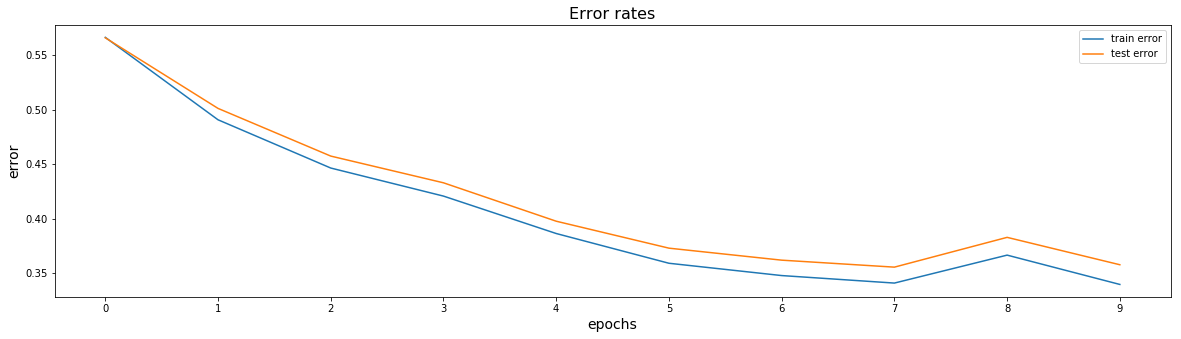

Epoch,Training,Test
1,56.622%,56.580%
2,49.066%,50.110%
3,44.644%,45.740%
4,42.072%,43.290%
5,38.642%,39.770%
6,35.916%,37.300%
7,34.788%,36.200%
8,34.100%,35.560%
9,36.662%,38.290%
10,33.974%,35.780%


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data imported from Tensorboard
train_err = [0.5662199854850769, 0.49066001176834106, 0.4464400112628937, 0.42072001099586487, 
             0.38642001152038574, 0.35916000604629517, 0.3478800058364868, 0.3409999907016754, 
             0.3666200041770935, 0.33974000811576843]
test_err = [0.5658000111579895, 0.5011000037193298, 0.45739999413490295, 0.43290001153945923, 
            0.3977000117301941, 0.37299999594688416, 0.3619999885559082, 0.3555999994277954, 
            0.3828999996185303, 0.3578000068664551]

fig = plt.figure(figsize=(20,5))
plt.plot(range(len(train_err)), train_err, label='train error')
plt.plot(range(len(test_err)), test_err, label='test error')
plt.xlabel('epochs', fontsize=14)
plt.ylabel('error', fontsize=14)
plt.xticks(range(10))
plt.title('Error rates', fontsize=16)
plt.legend()
plt.show()

from IPython.display import display, HTML

def display_as_table():
    # table
    caption_style = 'color:black;font-size:medium;text-align:center;'
    caption = '<caption style="{}">{}</caption>'.format(caption_style, 'Error rates')
    table = '<table>{}</table>'
    header = '<tr><th>{}</th></tr>'.format('</th><th>'.join(['Epoch','Training', 'Test']))
    values = ''
    for i, (train, test) in enumerate(zip(train_err, test_err)):
        values+='<tr><td>{}</td><td>{:.3f}%</td><td>{:.3f}%</td></tr>'.format(i+1, train*100, test*100)   
    
    html_output = table.format(caption+header+values)
    display(HTML(html_output))

    
display_as_table()

## 2. Understanding CNN (5 points + 3 bonus points)
** You should do all these tasks using TensorBoard! It is much more convenient than trying to achieve the same in numpy+matplotlib. To get visualizations all you need is to use tf.summary.image() with correct tensor, which is properly reshaped if it's needed.**

a. Now we will try to understand what CNNs actually learned. Let's do the following:
- Visualize all convolutional filters on all the layers. So you have to visualize 10 conv. filters (5x5) on the 1st layer, 20 conv. filters (4x4) on the 2nd layer and 30 conv. filters (3x3) on the 3-rd layer. Note, that each filter on the 1st layer has 3 input channels, which correspond to red, green and blue colors, so you can display them **in color**. And each filter on other layers has more input channels that have nothing to do with color. So you can just pick 1 of the input channels and display all conv. filters (again, 20 on 2nd layer and 30 on 3rd layer) **in grayscale** that correspond to a particular input channel. Please, provide here a few received images that you find interesting. (1 point)

- Visualize all feature maps (of size 32x32, 16x16, 8x8), i.e. values of neurons after applying activation function (and before the pooling operation) for each convolutional layer for any 5 training examples. Please, provide here a few received images that you find interesting. (1 point)

In the first layer, we can see that the feature maps represent a decomposition of the object in the image into different components.  
For example, here we can see that it decomposes the car on the image into front, wheels, lower part etc:  
![wheels - (conv1 fmap channel2)](conv1_activation_channel2_fmap4.png)  
![lower part - (conv1_fmap channel5](conv1_activation_channel5_fmap4.png)  
![front part - (conv1 fmap channel1](conv1_activation_channel1_fmap4.png)  

The next layers don't allow any easy visual interpretation, since those features have already been averaged via the preceding pooling operation.

- Can you notice some interesting patterns on the visualizations? Are all images perfectly interpretable? Discuss both images of convolutional filters and of feature maps on different layers. Are there duplicate filters that look almost identical? (1 point)

As stated before, the first layer features very well visible features that have been extracted from the input images and allow a straightforward interpretation. The next layers don't allow such easy interpretation.  
Some filters look identical in that they are zero everywhere, others look almost identical, probably because of averaging effects from the previous layers.

b. And now about the optimization process:
- Modify your code to plot the L2 norm of flattened gradients of the weights of each layer after each epoch. So your gradient for a convolutional layer is a tensor of dimension n_in x width x height x n_out (obtained by Optimizer.compute_gradients(loss)), so you should flatten it into a long vector and then take L2 norm of it. Please, also include the gradient magnitude immediately after random initialization. Make sure to calculate gradient magnitudes on the training set (or again, you can use only a subset of 1000 examples). (2 points)

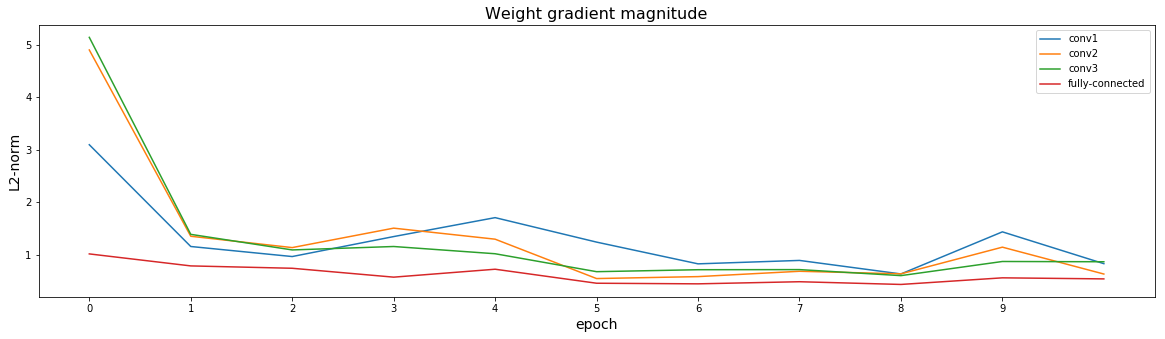

In [3]:
import matplotlib.pyplot as plt
## Data imported from Tensorboard

fc = [1.0131192207336426, 0.7844600081443787, 0.7394554615020752, 0.5702294707298279, 
      0.7212002873420715, 0.4544091522693634, 0.44282758235931396, 0.4831122159957886, 
      0.43129777908325195, 0.5572981834411621, 0.5371147394180298]

f1 = [3.093039035797119, 1.1542420387268066, 0.9627988934516907, 1.3433610200881958, 
      1.7041312456130981, 1.237857460975647, 0.8236730694770813, 0.8889564871788025, 
      0.6312859058380127, 1.433322787284851, 0.8271414637565613]

f2 = [4.898322582244873, 1.3492083549499512, 1.1334285736083984, 1.503750205039978, 
      1.2936478853225708, 0.5434404015541077, 0.5804846882820129, 0.6820647120475769, 
      0.6334681510925293, 1.1416524648666382, 0.6297425627708435]

f3 =  [5.138644218444824, 1.385654330253601, 1.0888524055480957, 1.1540793180465698, 
       1.016248106956482, 0.6744814515113831, 0.7118229269981384, 0.7141148447990417, 
       0.599384605884552, 0.8686579465866089, 0.8635902404785156]

fig = plt.figure(figsize=(20,5))
plt.plot(range(len(f1)), f1, label='conv1')
plt.plot(range(len(f2)), f2, label='conv2')
plt.plot(range(len(f3)), f3, label='conv3')
plt.plot(range(len(fc)), fc, label='fully-connected')
plt.xticks(range(10))
plt.title('Weight gradient magnitude', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('L2-norm', fontsize=14)
plt.legend()
plt.show()

- (BONUS, 3 points) Can you explain why the gradient magnitude doesn't always decrease over time? Can you confirm the picture from Deep Learning book on the page 281, figure 8.1, where the gradient magnitude strictly grows with training? 

## 3. Small questions about CNNs (5 points)
**Please, make sure to provide enough arguments and explanations to your answers.**


a. How many parameters do you have in total? In which layer you have the most of them? Is there any redundancy? (1 point)

b. Is it possible to represent a 3x3 convolution operation (for simplicity, let’s assume that we have a single color channel) as a matrix multiplication? If yes, state the form of the matrix. If no, explain why. (2 point)

Yes, we can represent a convolution with a kernel $K$ with shape $3\times 3$ and an input $X$ of shape $n\times m\times 1$ as follows: 
- reshape the input into a column vector $X'$ of length $n \cdot m$  
- create sparse matrix $K'$ composed as follows  

$$ 
\begin{align}
K'_1  &= 
\begin{bmatrix}
k_1 & k_2 & k_3 & 0^{m-3} & k_4     & k_5 & k_6 & 0^{m-3} & k_7     & k_8 & k_9 & 0^{m-3} & 0^{(n-3)*m}\\
0   & k_1 & k_2 & k_3     & 0^{m-4} & 0 & k_4 & k_5 & k_6     & 0^{m-4} & 0 & k_7 & k_8 & k_9 & 0^{m-4} & 0^{(n-3)*m}\\
0   &  0  & k_1 & k_2 & k_3 & 0^{m-5} & 0 & 0 & k_4 & k_5 & k_6 & 0 & 0 & k_7 & k_8 & k_9 & 0^{m-5} & 0^{(n-3)*m}\\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots\\
0^{m-3} & k_1 & k_2 & k_3 & 0^{m-3} & k_4 & k_5 & k_6 & 0^{m-3} & k_7 & k_8 & k_9 & 0^{(n-3)*m}\\
\end{bmatrix}\\[10pt]
K'_2 &= 
\begin{bmatrix}
0^{m} & k_1 & k_2 & k_3 & 0^{m-3} & k_4     & k_5 & k_6 & 0^{m-3} & k_7     & k_8 & k_9 & 0^{m-3} & 0^{(n-4)*m}\\
0^{m} & 0   & k_1 & k_2 & k_3     & 0^{m-4} & 0 & k_4 & k_5 & k_6     & 0^{m-4} & 0 & k_7 & k_8 & k_9 & 0^{m-4} & 0^{(n-4)*m}\\
0^{m} & 0   &  0  & k_1 & k_2 & k_3 & 0^{m-5} & 0 & 0 & k_4 & k_5 & k_6 & 0 & 0 & k_7 & k_8 & k_9 & 0^{m-5} & 0^{(n-4)*m}\\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots\\
0^{m} & 0^{m-3} & k_1 & k_2 & k_3 & 0^{m-3} & k_4 & k_5 & k_6 & 0^{m-3} & k_7 & k_8 & k_9 & 0^{(n-4)*m}\\
\end{bmatrix}\\[10pt]
& \cdots\\[10pt] 
K'_j &= 
\begin{bmatrix}
0^{(n-3)*m} & k_1 & k_2 & k_3 & 0^{m-3} & k_4 & k_5 & k_6 & 0^{m-3} & k_7 & k_8 & k_9 & 0^{m-3}\\
0^{(n-3)*m} & 0 & k_1 & k_2 & k_3 & 0^{m-4} & 0 & k_4 & k_5 & k_6 & 0^{m-4} & 0 & k_7 & k_8 & k_9 & 0^{m-4}\\
0^{(n-3)*m} & 0 & 0 & k_1 & k_2 & k_3 & 0^{m-5} & 0 & 0 & k_4 & k_5 & k_6 & 0^{m-5} & 0 & 0 & k_7 & k_8 & k_9 & 0^{m-5}\\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots\\
0^{(n-3)*m} & 0^{m-3} & k_1 & k_2 & k_3 & 0^{m-3} & k_4 & k_5 & k_6 & 0^{m-3} & k_7 & k_8 & k_9
\end{bmatrix}
\end{align}
$$

with j = n-3 +1 = n-2 and $K_j$ the matrix where the rows represent moving the kernel one step to the right where the top left element is in the jth row.  
$0^t$ represents $t$ zero row elements, e.g. $0^3 = \begin{pmatrix} 0 & 0 & 0 \end{pmatrix}$ 
 
$$
K' = \begin{bmatrix} K'_1 \\ K'_2 \\ \vdots \\ K'_j \end{bmatrix}
$$

Then the covolution is:  
$$
\begin{align}
K * X & = K' \cdot X' \\[10pt]
      & = \begin{bmatrix} K'_1 \\ \vdots \\ K'_j \end{bmatrix} \cdot 
      \begin{bmatrix} x_{11} \\ \vdots \\ x_{1m} \\ x_{21} \\ \vdots \\ x_{2m} \\ \vdots \\ x_{n1} \\ \vdots \\ x_{nm} \end{bmatrix}\\[10pt]
      & = \begin{bmatrix} 
            x_{11}k_1 + x_{12}k_2 + x_{13}k_3 + x_{21}k_4 + x_{22}k_5 + x_{23}k_6 + x_{31}k_7 + x_{32}k_8 + x_{33}k_9 \\
            x_{12}k_1 + x_{13}k_2 + x_{14}k_3 + x_{22}k_4 + x_{23}k_5 + x_{24}k_6 + x_{32}k_7 + x_{33}k_8 + x_{34}k_9 \\
            \cdots\\
            x_{1(m-2)}k_1 + x_{1(m-1)}k_2 + x_{1m}k_3 + x_{2(m-2)}k_4 + x_{2(m-1)}k_5 + x_{2m}k_6 + x_{3(m-2)}k_7 + x_{3(m-1)}k_8 + x_{3m}k_9 \\
            x_{22}k_1 + x_{23}k_2 + x_{24}k_3 + x_{32}k_4 + x_{33}k_5 + x_{34}k_6 + x_{42}k_7 + x_{43}k_8 + x_{44}k_9 \\
            \cdots\\
            x_{2(m-2)}k_1 + x_{2(m-1)}k_2 + x_{2m}k_3 + x_{3(m-2)}k_4 + x_{3(m-1)}k_5 + x_{3m}k_6 + x_{4(m-2)}k_7 + x_{4(m-1)}k_8 + x_{4m}k_9 \\
            \cdots\\
            x_{(n-2)1}k_1 + x_{(n-2)2}k_2 + x_{(n-2)3}k_3 + x_{(n-1)1}k_4 + x_{(n-1)2}k_5 + x_{(n-1)3}k_6 + x_{n1}k_7 + x_{n2}k_8 + x_{n3}k_9 \\
            \cdots\\
            x_{(n-2)(m-2)}k_1 + x_{(n-2)(m-1)}k_2 + x_{(n-2)m}k_3 + x_{(n-1)(m-2)}k_4 + x_{(n-1)(m-1)}k_5 + x_{(n-1)m}k_6 + x_{n(m-2)}k_7 + x_{n(m-1)}k_8 + x_{nm}k_9
            \end{bmatrix}\\[10pt]
  & = \begin{bmatrix} x'_{1} \\ x'_{2} \\ \vdots \\ x'_{(n-2)\cdot (m-3)} \end{bmatrix}
\end{align}
$$

We can then reshape the output into a matrix of shape $ (n-2) \times (m-3)$:  
$$
\begin{bmatrix}
x'_{1} & x'_{2} & \cdots & x'_{m-3}\\
x'_{m-2} & x'_{m-1} & \cdots & x'_{2\cdot(m-3)}\\
\vdots   & \vdots   & \vdots & \vdots \\
x'_{(n-2)\cdot(m-2)} & x'_{(n-2)\cdot(m-1)} & \cdots & x'_{(n-2)\cdot(m-3)}
\end{bmatrix}
$$

c. Applying dropout to convolutional layers may improve your test performance (for you interest, e.g. here [Wide Residual Networks](https://arxiv.org/pdf/1605.07146.pdf)). How could you explain this? (1 point)

Droput can be used to prevent feature coadaptation and overfitting in the convolutional layers. Less overfitting allows the network to generalize better and therefore results in a better test performance.

d. What is the role of Global Average Pooling that you already implemented in the task 1 (if you are curious, it was proposed in [Network in Network](https://arxiv.org/pdf/1312.4400.pdf))? What is the advantage of using it instead of concatenating all feature maps from the last convolutional layer and using a fully-connected layer on top of them? (1 point)

In the case of concatenating the feature maps and using a fully-connected layer it is difficult to interpret the class level information that is being fed into the softmax layer as the fully connected layer obfuscates this information.  
The GAP layer helps with this as it enforces correspondence between feature maps and classes.  
Also, the fc-layer only solution is very prone to overfitting and needs additional regularization (e.g. in form of dropout) while the GAP layer acts naturally as a regularizer and prevents overfitting since there are no additional parameters that are being optimized. It also has the additional benefit of introducing invariance w.r.t spatial translations.

## Bonus task (1 place: 15 pts, 2 place: 10 pts, 3 place: 5 pts)
Now you are free to implement any CNN architecture in order to get **as low test error rate as possible** on CIFAR-10. You can train the model for arbitrary number of epochs, it can have any number of layers and neurons, you can use different data preprocessing techniques, data augmentation, pooling, dropout, model averaging and much more. 

You also can use research papers for inspiration. For example, here is a [collection](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) of best published results, however it is slightly outdated.

#### Main rules:
- Your final test error should be **reproducible**.
- You must describe your main architecture decisions and why they make sense for the given task.
- You are not allowed to copy and paste CNN architectures from the internet. It should be self-written TF code. We will check this.
- Obviously, you are not allowed to train on test data.
- If you want to take part in the competition, you should submit a **separate python file** which does the training of your model and that outputs test errors for each epoch (evaluated on all 10000 test examples). It will be more convenient format for us to reproduce your results.

*Note: of course, people who have an access to more computational resources have an advantage in this task. However, even if you have an old laptop, you still can perform well and test many models. For example, you can train and evaluate your model only on a subset of the dataset (e.g. 1000 examples), which significantly speeds up the process. You can leave expensive hyperparameter tuning overnight. And of course, you are encouraged to collaborate with your teammates, which also have computational resources.*

## Submission instructions
You should provide a single Jupyter notebook as a solution. The naming should include the assignment number and matriculation IDs of all team members in the following format:
**assignment-10_matriculation1_matriculation_2_matriculation3.ipynb** (in case of 3 team members). 
Make sure to keep the order matriculation1_matriculation_2_matriculation3 the same for all assignments.

Please, submit your solution to your tutor (with **[NNIA][assignment-10]** in email subject):
1. Maksym Andriushchenko <s8mmandr@stud.uni-saarland.de>
2. Marius Mosbach <s9msmosb@stud.uni-saarland.de>
3. Rajarshi Biswas <rbisw17@gmail.com>
4. Marimuthu Kalimuthu <s8makali@stud.uni-saarland.de>

**If you are in a team, please submit only 1 solution to only 1 tutor.**